<a href="https://colab.research.google.com/github/alracey/level4-project/blob/main/piecewise_quadratic_1d_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

torch.__version__

'2.9.0+cu126'

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


This section defines the target function f.

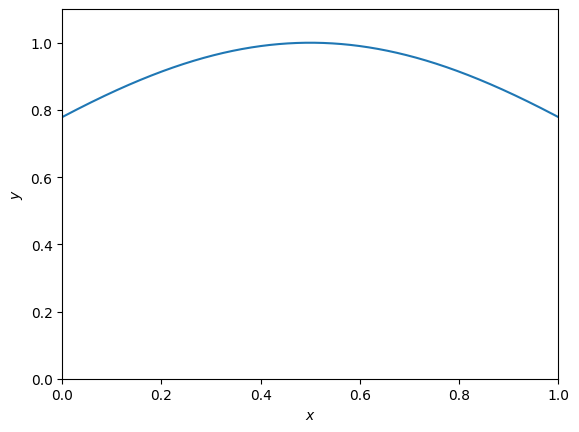

In [3]:
def f(x):
  return torch.exp(-((x-0.5)**2))

def plot_f(N):
  xs = torch.linspace(0, 1, N)
  f_evals = f(xs)

  fig = plt.figure()
  plt.plot(xs, f_evals)
  plt.xlabel('$x$')
  plt.ylabel('$y$')
  plt.xlim(0, 1)
  plt.ylim(0, 1.1)
  plt.show()

  return fig

test = plot_f(1000)


REMEMBER you have now changed the definition of params to include the endpoints, to allow testing with the identity transformation.
D has been included to minimise changes from the 2D plus case but this means you must be careful with squeezing and unsqueezing.

In [6]:
### Example parameters for testing ###

D, n, K = 1, 10, 8

x = torch.rand(n)
params = torch.tensor([0.5, 0.4, 0.5, 0.4, 0.5, 0.4, 0.5, 0.4, 0.5])

This defines a function which, for a given set of parameters, returns the corresponding normalised pdf heights and bin areas (for constant bin widths)

In [4]:
def preprocess_params(params):
    """
    params: (D, K+1) unnormalised PDF heights
    returns:
      v:         (D, K+1) normalised PDF heights
      bin_areas: (D, K)   normalised bin areas
    """
    D, Kp1 = params.shape
    K = Kp1 - 1

    bins = torch.linspace(0, 1, K+1, device=params.device).repeat(D, 1)

    v = params
    v_left = v[:, :-1]
    v_right = v[:, 1:]
    bin_widths = bins[:, 1:] - bins[:, :-1]

    bin_areas = 0.5 * (v_left + v_right) * bin_widths
    total_area = bin_areas.sum(dim=1, keepdim=True)

    # normalise
    v = v / total_area
    bin_areas = bin_areas / total_area

    return v, bin_areas


This section defines the piecewise quadratic transform g which returns the cumulative distribution values for an input x corresponding to the given parameters.

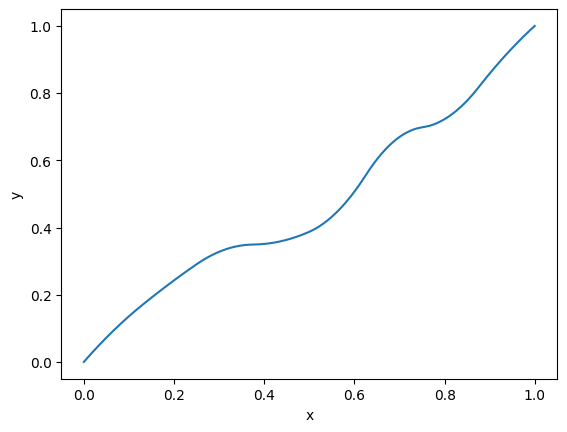

tensor(0.0004) tensor(0.9996)


In [8]:
def g(x, params):

  '''
  PARAMS NOW INCLUDES ZEROS AND ONES TO SKIP CONCATENATING
  Piecewise quadratic transform with K bins, independent in different dimensions.
  This version does not yet predict bin widths.
  x.shape = (D, n); params.shape = (D, K+1) where D is dimensions, K is number of bins.
  torch.bucketize only works here for random inputs - must sort for plotting
  x ---> y
  '''

  device = x.device
  dtype = x.dtype

  #bins
  D, n = x.shape
  K = params.size(1) - 1

  #bin edges
  bins = torch.linspace(0, 1, K+1, device=device, dtype=dtype).repeat(D, 1)   #edges

  #find indices
  i_values = []
  for d in range(D):
    i_d = torch.bucketize(x[d], bins[d], right=False) - 1
    i_values.append(i_d)

  i_values = torch.stack(i_values, dim=0)   # shape (D, n)

  v, bin_areas = preprocess_params(params)

  #create row indices
  row_indices = torch.arange(D, device=device).unsqueeze(1)    #shape (D, 1)

  #bin edges
  x_left = bins[row_indices, i_values]    #shape (D, n)
  x_right = bins[row_indices, i_values+1]
  w_b = x_right - x_left   #shape (D, n)

  #pdf heights
  v_left = v[row_indices, i_values]
  v_right = v[row_indices, i_values+1]
  w_v = v_right - v_left    #slope of pdf inside bin (linear)

  #transform to local coordinate alpha
  alpha = (x - x_left) / (w_b + 1e-12)    #avoid instability

  #cumulative area to left of x values
  cum_areas = torch.zeros(D, n, device=device, dtype=dtype)
  for d in range(D):
    for i in range(n):
      cum_areas[d, i] = torch.sum(bin_areas[d, :i_values[d, i]])

  c_left = cum_areas

  #compute quadratic mappings
  result = c_left + ((alpha**2/2) * w_v * w_b) + (alpha * v_left * w_b)
  return result   #quadratic in alpha with shape (D, n)


#test

x_test = torch.rand(D, 1000)
x_test = x_test.sort(dim=1).values
params = torch.rand(D, 9)
g_test = g(x_test, params)
plt.plot(x_test.squeeze(), g_test.squeeze())
plt.xlabel('x')
plt.ylabel('y')
plt.show()
print(g_test.squeeze()[0], g_test.squeeze()[-1])

Debugging h

In [ ]:
### experimenting with h ###

cdf_values = g_test
v, bin_areas = preprocess_params(params.unsqueeze(0)) # Unsqueeze params to make it (D, K+1)

#bins
bins = torch.linspace(0, 1, K+1).repeat(D, 1)


#v_left_for_areas = v[:, :-1]
#v_right_for_areas = v[:, 1:]
#bin_widths = bins[:, 1:] - bins[:, :-1]
#bin_areas = 0.5 * (v_left_for_areas + v_right_for_areas) * bin_widths #trapezium rule
c_edges = torch.zeros((D, K+1))   #cdf starts at 0
c_edges[:, 1:] = torch.cumsum(bin_areas, dim=1)

j_values = []
for d in range(D):
  j_d = torch.bucketize(cdf_values[d], c_edges[d], right=False) - 1
  j_values.append(j_d.clamp(min=0, max=K-1))

j_values = torch.stack(j_values, dim=0)   #these are correct so far

row_indices = torch.arange(D).unsqueeze(1)

#compute the edge positions
x_left = bins[row_indices, j_values]
x_right = bins[row_indices, j_values+1]
w_b = x_right - x_left    #bin width(s)

c_left = c_edges[row_indices, j_values]

v_left = v[row_indices, j_values]
v_right = v[row_indices, j_values+1]
w_v = v_right - v_left    #vertex differences

#solve quadratic to obtain alpha values

# coefficients
a = 0.5 * w_v * w_b
b = v_left * w_b
c = c_left - cdf_values

# linear vs quadratic bins
is_linear = torch.abs(w_v) < 1e-12

alpha = torch.empty_like(cdf_values)

# linear case
alpha[is_linear] = (cdf_values[is_linear] - c_left[is_linear]) / (
    v_left[is_linear] * w_b[is_linear]
)

# quadratic case
disc = torch.clamp(b*b - 4*a*c, min=0.0)
alpha[~is_linear] = (
    -b[~is_linear] + torch.sqrt(disc[~is_linear])
) / (2*a[~is_linear])

#obtain x values

x = x_left + (w_b*alpha)
jac = 1 / (v_left + w_v * alpha)
#jac_det = jac.prod(dim=0)

print('cdf_values:', cdf_values)
print('c_edges:', c_edges)
print('j_values:', j_values)
print('x_left:', x_left)
print('x_right:', x_right)
print('w_b:', w_b)
print('c_left:', c_left)
print('v:', v)
print('v_left:', v_left)
print('v_right:', v_right)
print('w_v:', w_v)
print('alphas:', alpha)
print('x:', x)
print('Jacobians:', jac)
print('h:', f(x) * jac)

ValueError: too many values to unpack (expected 2)

This section defines the transformed function h using the change of variables formula to preserve the integral value.

In [9]:
def h(y, params):

  '''
  Resulting function when the piecewise warp is applied, in accordance with change of variables formula.
  Integral should be preserved.
  '''

  device = y.device
  dtype = y.dtype

  D, n = y.shape
  K = params.size(1) -1

  #bins
  bins = torch.linspace(0, 1, K+1, device=device, dtype=dtype).repeat(D, 1)

  v, bin_areas = preprocess_params(params)

  #cumulative areas

  c_edges = torch.zeros((D, K+1), device=device, dtype=dtype)   #cdf starts at 0
  c_edges[:, 1:] = torch.cumsum(bin_areas, dim=1)

  #find indices
  j_values = []
  for d in range(D):
    j_d = torch.bucketize(y[d], c_edges[d], right=False) - 1
    j_values.append(j_d)

  j_values = torch.stack(j_values, dim=0)

  row_indices = torch.arange(D, device=device).unsqueeze(1)

  #compute the edge positions
  x_left = bins[row_indices, j_values]
  x_right = bins[row_indices, j_values+1]
  w_b = x_right - x_left    #bin width(s)

  c_left = c_edges[row_indices, j_values]

  v_left = v[row_indices, j_values]
  v_right = v[row_indices, j_values+1]
  w_v = v_right - v_left    #vertex differences

  #solve quadratic to obtain alpha values

  # coefficients
  a = 0.5 * w_v * w_b
  b = v_left * w_b
  c = c_left - y

  # linear vs quadratic bins
  is_linear = torch.abs(w_v) < 1e-12

  alpha = torch.empty_like(y, device=device, dtype=dtype)

  # linear case
  alpha[is_linear] = (y[is_linear] - c_left[is_linear]) / (
      v_left[is_linear] * w_b[is_linear]
  )

  # quadratic case
  disc = torch.clamp(b*b - 4*a*c, min=0.0)
  alpha[~is_linear] = (
      -b[~is_linear] + torch.sqrt(disc[~is_linear])
  ) / (2*a[~is_linear])

  #jacobians

  jac = 1 / (v_left + (w_v*alpha))

  #obtain x values
  x = x_left + (w_b*alpha)

  return f(x) * jac


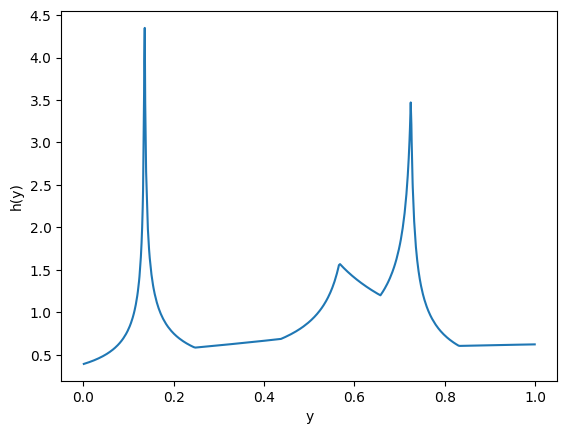

In [10]:
#test plot of h

y_test = torch.rand(1000)
y_test_sorted = torch.sort(y_test).values
params = torch.rand(9)
h_test = h(y_test_sorted.unsqueeze(0), params.unsqueeze(0))
#print(h_test)
plt.plot(y_test_sorted, h_test.squeeze(0))
plt.xlabel('y')
plt.ylabel('h(y)')
plt.show()

Checking integral preservation and variance

In [11]:
#check integral is preserved using (naive) MC

###REFERENCE VALUE: 0.922562###
N = 1000000
#torch.manual_seed(42)
test_params = params

def MC_F(N):
  x = torch.rand(N)
  f_evals = f(x)
  F_est = torch.mean(f_evals)
  alpha_F = torch.std(f_evals) / torch.sqrt(torch.tensor(N))
  return F_est, alpha_F

def MC_H(N, params):
  y = torch.rand(N)
  h_evals = h(y.unsqueeze(0), params) # Unsqueezing y to (1, N) to match h's expected (D, n) input
  H_est = torch.mean(h_evals)
  alpha_H = torch.std(h_evals) / torch.sqrt(torch.tensor(N))
  return H_est, alpha_H

F_est, alpha_F = MC_F(N)
print(f'F estimate = {F_est} \u00b1 {alpha_F}')

H_est, alpha_H = MC_H(N, params.unsqueeze(0))
print(f'H estimate = {H_est} \u00b1 {alpha_H}')

F estimate = 0.9224910140037537 ± 6.70864901621826e-05
H estimate = 0.9227722883224487 ± 0.0004983028047718108


In [12]:
#check that variances are different in general
test_set = torch.rand(D, N)

f_var = torch.var(f(test_set))

h_for_var = h(test_set, test_params.unsqueeze(0)) # Unsqueeze test_params to make it (D, K+1)
h_var = torch.var(h_for_var)

print("F variance:", f_var)
print("H variance:", h_var)

F variance: tensor(0.0045)
H variance: tensor(0.2481)


Defining the training loop for optimisation of parameters in order to minimise variance

In [13]:
#function enforcing positivity and enabling unconstrained parameters

def positive_params(params):
  return torch.nn.functional.softplus(params) + 1e-9

print(positive_params(torch.zeros(D, K+1)))

tensor([[0.6931, 0.6931, 0.6931, 0.6931, 0.6931, 0.6931, 0.6931, 0.6931, 0.6931]])


In [14]:
#optimisation via training loop - loss function is the variance

def train_loop(x, K, epochs, lr, device, ticker):
  '''
  x.shape = (D, n); K bins, D dimensions
  '''
  if device is None:
    device = x.device

  D = x.size(0)
  u_params = torch.rand((D, K+1), device=device, requires_grad=True)
  optimiser = torch.optim.Adam([u_params], lr=lr)
  scheduler = torch.optim.lr_scheduler.ExponentialLR(optimiser, gamma=0.99)
  loss_values = torch.zeros(epochs, device=device)
  max_norm = 0.1

  for epoch in range(epochs):
    params = positive_params(u_params)
    g_eval = g(x, params)
    h_eval = h(g_eval, params)

    loss = torch.var(h_eval)
    loss_values[epoch] = loss

    optimiser.zero_grad()

    loss.backward()

    total_norm = torch.nn.utils.clip_grad_norm_(u_params, max_norm)

    optimiser.step()

    before_lr = optimiser.param_groups[0]["lr"]
    scheduler.step()
    after_lr = optimiser.param_groups[0]["lr"]
    #if epoch % 10 == 0:
      #print("Epoch %d: lr %.9f -> %.9f" % (epoch, before_lr, after_lr))
      #print(f"Grad norm (pre-clip): {total_norm:.8f}")

    if ticker == True:
      if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss}")

  final_loss = loss

  return final_loss, loss_values, positive_params(u_params)

train_x = torch.rand(D, 1000, device='cpu')


In [15]:
final_loss, loss_values, opt_params = train_loop(train_x, K=8, epochs=200, lr=0.03, device=None, ticker=True)
print("Final loss:", final_loss.item())
print("Optimised parameters:", opt_params)

Epoch: 0 | Loss: 0.01944052241742611
Epoch: 10 | Loss: 0.002387150889262557
Epoch: 20 | Loss: 0.0006741760880686343
Epoch: 30 | Loss: 0.00028447198565118015
Epoch: 40 | Loss: 0.00010851308616111055
Epoch: 50 | Loss: 2.5402299797860906e-05
Epoch: 60 | Loss: 1.585668906045612e-05
Epoch: 70 | Loss: 4.904311936115846e-06
Epoch: 80 | Loss: 2.040076651610434e-06
Epoch: 90 | Loss: 1.4573740827472648e-06
Epoch: 100 | Loss: 8.721783046894416e-07
Epoch: 110 | Loss: 8.560096489418356e-07
Epoch: 120 | Loss: 8.345883770743967e-07
Epoch: 130 | Loss: 8.064689041020756e-07
Epoch: 140 | Loss: 8.006388725334546e-07
Epoch: 150 | Loss: 8.00038378656609e-07
Epoch: 160 | Loss: 7.996217732397781e-07
Epoch: 170 | Loss: 7.994598831828625e-07
Epoch: 180 | Loss: 7.994040061021224e-07
Epoch: 190 | Loss: 7.99376778104488e-07
Final loss: 7.99370241111319e-07
Optimised parameters: tensor([[0.8943, 0.9984, 1.0798, 1.1319, 1.1497, 1.1321, 1.0797, 0.9983, 0.8944]],
       grad_fn=<AddBackward0>)


Making a plot comparing the original function f to the transformed function h with optimised parameters.  

tensor(8.9071e-07)


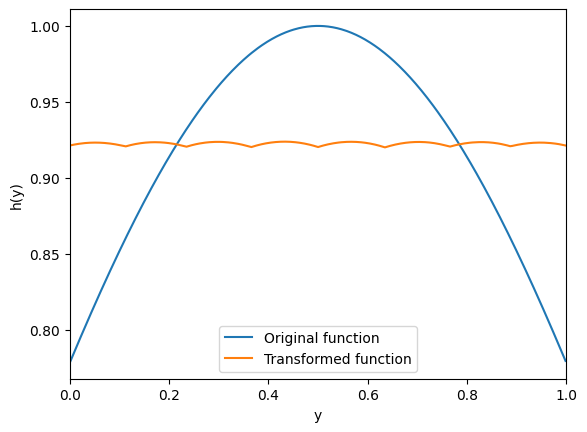

In [16]:
#plot of h with optimised parameters, comparing to original function

opt_params = opt_params.detach().cpu()
y_plot = torch.sort(torch.rand(1000)).values
h_test = h(y_plot.unsqueeze(0), opt_params)
print(torch.var(h_test))
plt.plot(y_plot, f(y_plot), label='Original function')
plt.plot(y_plot, h_test.squeeze(0), label='Transformed function')

plt.xlim(0, 1)
#plt.ylim(0.85, 1)
plt.legend()
plt.xlabel('y')
plt.ylabel('h(y)')
plt.show()

This section is purely for visualisation/analysis tools - variation of loss with epoch, final loss vs number of bins, loss vs epoch for different learning rates, histogram of function evaluations for variance estimates.

In [ ]:
#loss vs epoch for different K

device = train_x.device
dtype = train_x.dtype

K_s = [2, 4, 8, 16, 32, 64]
epochs = 220
loss_values = torch.zeros((len(K_s), epochs), device=device, dtype=dtype)

# train_x is defined in a previous cell with D, 1000 dimensions
for i in range(len(K_s)):
  loss_values[i] = train_loop(train_x, K_s[i], epochs, lr=0.03, device=device, ticker=False)[1]


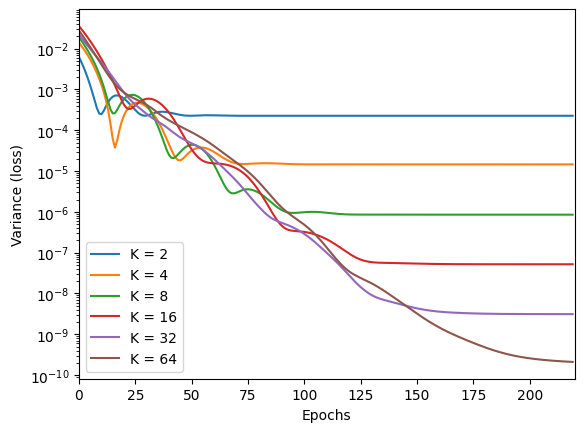

In [ ]:
#plotting
epochs_plot = torch.arange(epochs, device='cpu')
plt.figure()
for i in range(len(K_s)):
  plt.plot(epochs_plot, loss_values[i].detach().cpu().numpy(), label=f'K = {K_s[i]}')

plt.xlabel('Epochs')
plt.ylabel('Variance (loss)')
plt.legend()
plt.xlim(0, 220)
plt.yscale('log')
plt.show()

In [ ]:
#generate data

Ks = range(2, 65)
vars = torch.zeros(len(Ks))
i=0

for K in Ks:
  if K >= 60:
    epochs = 230
  else:
    epochs = 200
  result = train_loop(train_x, K, epochs=epochs, lr=0.03, device=device, ticker=False)[0]
  vars[i] = result.reshape(1) # Reshape scalar to a 1D tensor
  i += 1

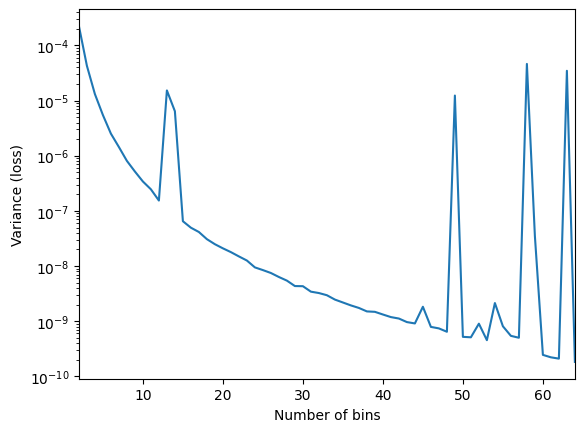

tensor([2.2566e-04, 4.2774e-05, 1.3136e-05, 5.4786e-06, 2.5172e-06, 1.4397e-06,
        8.0725e-07, 5.1802e-07, 3.4145e-07, 2.4652e-07, 1.5416e-07, 1.5279e-05,
        6.4114e-06, 6.5012e-08, 4.9647e-08, 4.1454e-08, 3.0759e-08, 2.4915e-08,
        2.0972e-08, 1.7900e-08, 1.4968e-08, 1.2604e-08, 9.4677e-09, 8.4584e-09,
        7.4909e-09, 6.3382e-09, 5.4494e-09, 4.3447e-09, 4.3178e-09, 3.4378e-09,
        3.2447e-09, 2.9625e-09, 2.4702e-09, 2.1877e-09, 1.9368e-09, 1.7422e-09,
        1.5073e-09, 1.4814e-09, 1.3250e-09, 1.1894e-09, 1.1195e-09, 9.6565e-10,
        9.1234e-10, 1.8311e-09, 7.8971e-10, 7.4188e-10, 6.4488e-10, 1.2339e-05,
        5.2150e-10, 5.1164e-10, 9.0314e-10, 4.5390e-10, 2.1365e-09, 8.1118e-10,
        5.4348e-10, 5.0210e-10, 4.6182e-05, 3.4966e-08, 2.4561e-10, 2.2181e-10,
        2.1003e-10, 3.4672e-05, 1.8306e-10], grad_fn=<CopySlices>)


In [ ]:
#plotting

plt.figure()
plt.plot(Ks, vars.detach().cpu().numpy()) # Detach and convert to numpy for plotting
plt.xlabel('Number of bins')
plt.ylabel('Variance (loss)')
plt.yscale('log')
plt.xlim(2, 64)
plt.show()
print(vars)   #check accuracy